Socila circles: Twitter
This dataset consists of 'circles' (or 'lists') from Twitter. 
Twitter data was crawled from public sources. 
The dataset includes node features (profiles), circles, and ego networks.

First we look at the info of the full datatset and then we view a sample from this dataset so that we can create a subset of it:

In [55]:
import networkx as nx
import random
from networkx.algorithms.distance_measures import diameter

#file_path = "twitter_combined.txt"  
#G = nx.read_edgelist(file_path)



# Create a subset of the graph (Example: nodes with degree > 50)
#degree_threshold = 50
#subset_nodes = [node for node, degree in dict(G.degree()).items() if degree > degree_threshold]
#s_G = G.subgraph(subset_nodes)



# Helper: Compute metrics safely with progress logs
def compute_metric(name, func, *args, **kwargs):
    try:
        print(f"Computing {name}...")
        return func(*args, **kwargs)
    except Exception as e:
        print(f"Error computing {name}: {e}")
        return "N/A"

def approximate_diameter(graph, sample_size=100):
    nodes = list(graph.nodes())
    sampled_nodes = random.sample(nodes, min(sample_size, len(nodes)))
    max_eccentricity = 0
    
    for node in sampled_nodes:
        eccentricity = max(nx.single_source_shortest_path_length(graph, node).values())
        max_eccentricity = max(max_eccentricity, eccentricity)
    
    return max_eccentricity

approx_diameter = approximate_diameter(subset_G)    


# Compute metrics for the subset
subset_metrics = {
    "Nodes": subset_G.number_of_nodes(),
    "Edges": subset_G.number_of_edges(),
    "Nodes in largest WCC": compute_metric("Nodes in largest WCC", lambda g: len(max(nx.connected_components(g), key=len)), subset_G),
    "Edges in largest WCC": compute_metric("Edges in largest WCC", lambda g: subset_G.subgraph(max(nx.connected_components(g), key=len)).number_of_edges(), subset_G),
    "Average clustering coefficient": compute_metric("Average clustering coefficient", nx.average_clustering, subset_G),
    "Number of triangles": compute_metric("Number of triangles", lambda g: sum(nx.triangles(g).values()) // 3, subset_G),
    "Fraction of closed triangles": compute_metric("Fraction of closed triangles", nx.transitivity, subset_G),
    "Approximate diameter": compute_metric("Approximate diameter", approximate_diameter, subset_G),
    }

# Output the subset metrics
print("\nSubset Metrics:")
for key, value in subset_metrics.items():
    print(f"{key}: {value}")


Computing Nodes in largest WCC...
Error computing Nodes in largest WCC: not implemented for directed type
Computing Edges in largest WCC...
Error computing Edges in largest WCC: not implemented for directed type
Computing Average clustering coefficient...
Computing Number of triangles...
Error computing Number of triangles: not implemented for directed type
Computing Fraction of closed triangles...
Computing Approximate diameter...

Subset Metrics:
Nodes: 1112
Edges: 7905
Nodes in largest WCC: N/A
Edges in largest WCC: N/A
Average clustering coefficient: 0.4974525489309039
Number of triangles: N/A
Fraction of closed triangles: 0.03160078901786867
Approximate diameter: 4


Central node: 813286


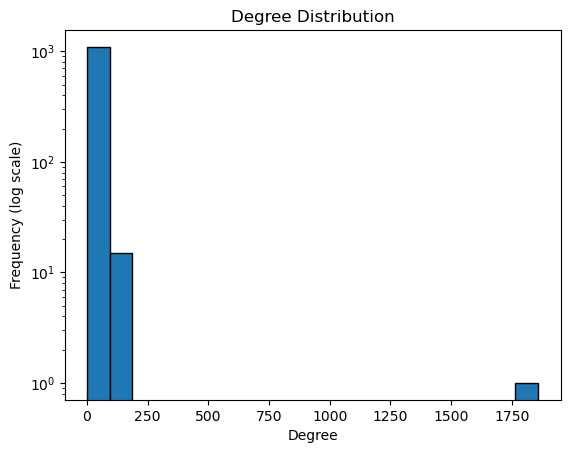

Computing Average clustering coefficient...
Computing Number of triangles...
Computing Fraction of closed triangles...

Subset Metrics:
Nodes: 1112
Edges: 7905
Nodes in largest WCC: 1112
Edges in largest WCC: 7905
Nodes in largest SCC: 967
Edges in largest SCC: 7553
Average clustering coefficient: 0.5758520841980064
Number of triangles: 15178
Fraction of closed triangles: 0.060499525665861496
Approximate diameter: 4
90-percentile effective diameter: 3.0
Number of communities: 14
Modularity score: 0.4942784308706154


In [57]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np

# Load graph as directed
file_path = "twitter_combined.txt"  # Replace with your dataset path
s_G = nx.read_edgelist(file_path, create_using=nx.DiGraph())

# Extract ego network for the central node
degree_centrality = nx.degree_centrality(s_G)
central_node = max(degree_centrality, key=degree_centrality.get)
print("Central node:", central_node)
subset_G = nx.ego_graph(s_G, central_node, radius=1, undirected=False)

# Helper: Compute metrics safely with progress logs
def compute_metric(name, func, *args, **kwargs):
    try:
        print(f"Computing {name}...")
        return func(*args, **kwargs)
    except Exception as e:
        print(f"Error computing {name}: {e}")
        return "N/A"

# Approximate diameter using random sampling
def approximate_diameter(graph, sample_size=100):
    nodes = list(graph.nodes())
    sampled_nodes = random.sample(nodes, min(sample_size, len(nodes)))
    max_eccentricity = 0
    for node in sampled_nodes:
        lengths = nx.single_source_shortest_path_length(graph, node)
        if lengths:
            eccentricity = max(lengths.values())
            max_eccentricity = max(max_eccentricity, eccentricity)
    return max_eccentricity

# Calculate 90-percentile effective diameter
def effective_diameter(graph, sample_size=1000):
    nodes = list(graph.nodes())
    sampled_pairs = random.sample([(u, v) for u in nodes for v in nodes if u != v], min(sample_size, len(nodes)**2))
    shortest_paths = []
    for source, target in sampled_pairs:
        try:
            path_length = nx.shortest_path_length(graph, source, target)
            shortest_paths.append(path_length)
        except nx.NetworkXNoPath:
            continue
    return np.percentile(shortest_paths, 90) if shortest_paths else "N/A"

# Compute degree distribution
def compute_degree_distribution(graph):
    degree_sequence = [degree for _, degree in graph.degree()]
    plt.hist(degree_sequence, bins=20, edgecolor="black", log=True)
    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency (log scale)")
    plt.savefig("degree_distribution.png", dpi=300)
    plt.show()
    return degree_sequence

# Compute modularity and communities
def compute_modularity(graph):
    communities = nx.community.louvain_communities(graph.to_undirected(), seed=42)
    modularity_score = nx.community.modularity(graph.to_undirected(), communities)
    return len(communities), modularity_score

# Compute SCC and WCC metrics
def compute_scc_wcc(graph):
    # Strongly Connected Components (SCC)
    largest_scc = max(nx.strongly_connected_components(graph), key=len, default=[])
    largest_scc_subgraph = graph.subgraph(largest_scc)
    num_scc_nodes = len(largest_scc)
    num_scc_edges = largest_scc_subgraph.number_of_edges()

    # Weakly Connected Components (WCC)
    largest_wcc = max(nx.weakly_connected_components(graph), key=len, default=[])
    largest_wcc_subgraph = graph.subgraph(largest_wcc)
    num_wcc_nodes = len(largest_wcc)
    num_wcc_edges = largest_wcc_subgraph.number_of_edges()

    return num_scc_nodes, num_scc_edges, num_wcc_nodes, num_wcc_edges

    
# Compute metrics for the directed subset graph
degree_distribution = compute_degree_distribution(subset_G)
approx_diameter = approximate_diameter(subset_G)
effective_diam = effective_diameter(subset_G)
num_communities, modularity_score = compute_modularity(subset_G)
nodes_in_scc, edges_in_scc, nodes_in_wcc, edges_in_wcc = compute_scc_wcc(subset_G)

subset_metrics = {
    "Nodes": subset_G.number_of_nodes(),
    "Edges": subset_G.number_of_edges(),
    "Nodes in largest WCC": nodes_in_wcc,
    "Edges in largest WCC": edges_in_wcc,
    "Nodes in largest SCC": nodes_in_scc,
    "Edges in largest SCC": edges_in_scc,
    "Average clustering coefficient": compute_metric("Average clustering coefficient", nx.average_clustering, subset_G.to_undirected()),
    "Number of triangles": compute_metric("Number of triangles", lambda g: sum(nx.triangles(g.to_undirected()).values()) // 3, subset_G),
    "Fraction of closed triangles": compute_metric("Fraction of closed triangles", nx.transitivity, subset_G.to_undirected()),
    "Approximate diameter": approx_diameter,
    "90-percentile effective diameter": effective_diam,
    "Number of communities": num_communities,
    "Modularity score": modularity_score,
}

# Output the subset metrics
print("\nSubset Metrics:")
for key, value in subset_metrics.items():
    print(f"{key}: {value}")


We now detect communities with the louvain algorithm and analyse them:

Total number of communities: 15
Sizes of communities: [40, 23, 23, 76, 68, 60, 60, 107, 9, 28, 54, 436, 74, 35, 19]


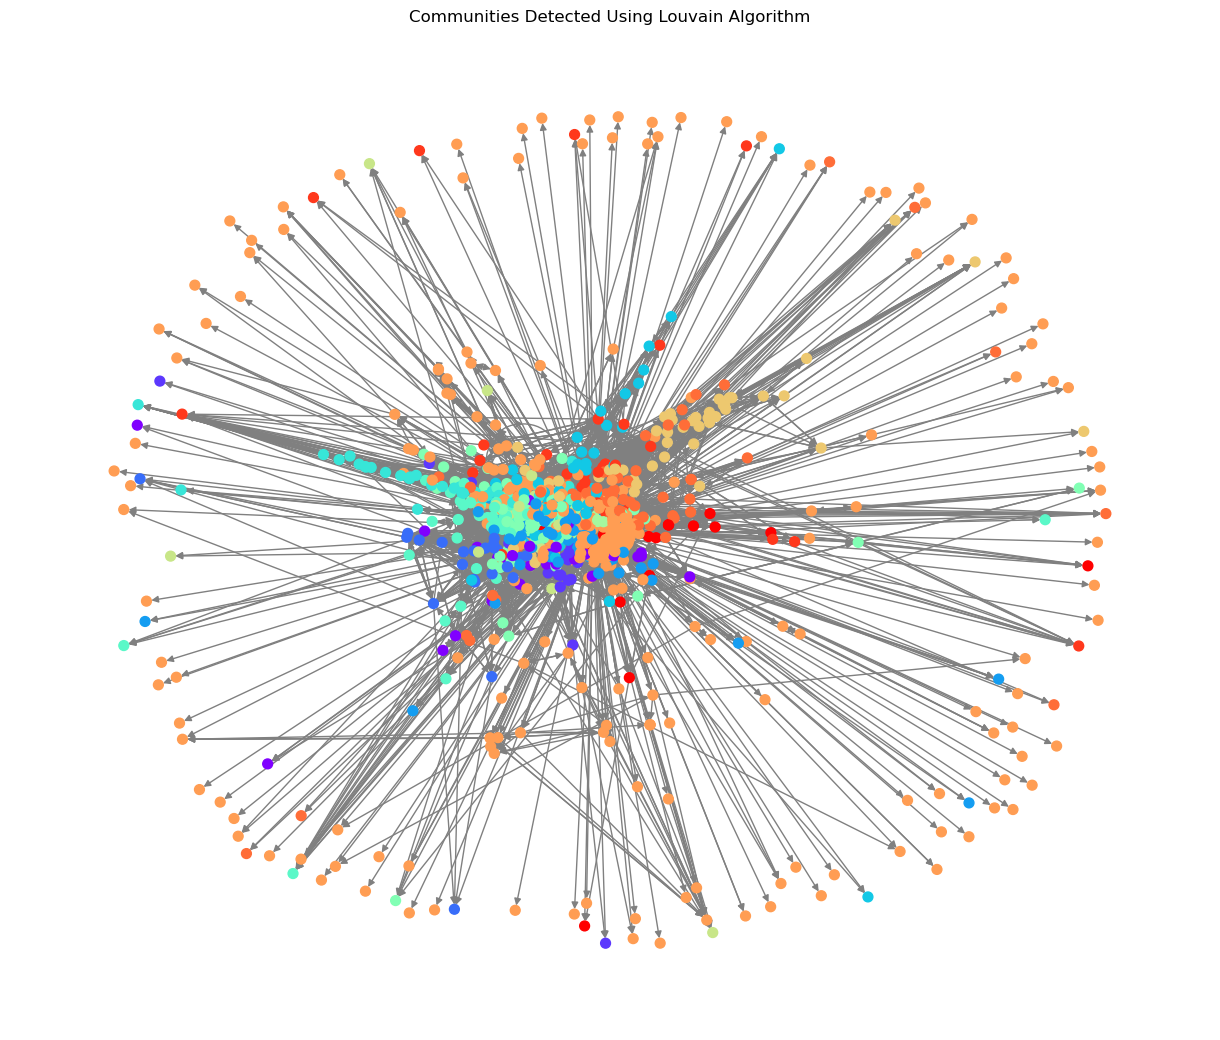

Number of internal edges in each community: [158, 84, 148, 374, 312, 314, 513, 1253, 42, 97, 266, 1058, 251, 148, 58]
Top central nodes in Community 0: [('25110374', 0.032403240324032405), ('3004231', 0.025202520252025202), ('23151437', 0.023402340234023402), ('16051471', 0.018901890189018902), ('17169320', 0.017101710171017102)]
Top central nodes in Community 1: [('18057537', 0.019801980198019802), ('17796018', 0.018001800180018002), ('8644082', 0.016201620162016202), ('2869531', 0.0144014401440144), ('21772005', 0.0144014401440144)]
Top central nodes in Community 2: [('746323', 0.0531053105310531), ('16134837', 0.026102610261026102), ('11148342', 0.025202520252025202), ('5485192', 0.025202520252025202), ('14986716', 0.022502250225022502)]
Top central nodes in Community 3: [('3359851', 0.1026102610261026), ('5442012', 0.045004500450045004), ('3040621', 0.037803780378037805), ('7872262', 0.0333033303330333), ('22784458', 0.0315031503150315)]
Top central nodes in Community 4: [('7861312

In [60]:
import networkx as nx
from networkx.algorithms.community import louvain_communities
import matplotlib.pyplot as plt

# Step 2: Run the Louvain Community Detection Algorithm
# Parameters: weight='weight', resolution=1, threshold=1e-07, max_level=None
communities = louvain_communities(subset_G, resolution=1, threshold=1e-07, seed=42)

# Number of communities
print(f"Total number of communities: {len(communities)}")

# Size of each community
community_sizes = [len(community) for community in communities]
print("Sizes of communities:", community_sizes)


# Step 3: Visualize the Communities
def visualize_communities(graph, communities):
    # Assign colors to nodes based on their community
    community_map = {node: idx for idx, community in enumerate(communities) for node in community}
    node_colors = [community_map[node] for node in graph.nodes()]
    
    # Generate layout for better visualization
    pos = nx.spring_layout(graph)

    # Draw the graph
    plt.figure(figsize=(12, 10))
    nx.draw(
        graph, pos,
        node_color=node_colors,
        with_labels=False,
        cmap=plt.cm.rainbow,
        node_size=50,
        edge_color="gray"
    )
    plt.title("Communities Detected Using Louvain Algorithm")
    
    # Save the plot
    plt.savefig("ScreenShots/louvain_communities.png", format="png", dpi=300)  # Save as PNG with high resolution
    plt.show()

# Call visualization
visualize_communities(subset_G, communities)


internal_edges = [subset_G.subgraph(community).number_of_edges() for community in communities]
print("Number of internal edges in each community:", internal_edges)

degree_centrality = nx.degree_centrality(subset_G)
for idx, community in enumerate(communities):
    centrality = {node: degree_centrality[node] for node in community}
    sorted_centrality = sorted(centrality.items(), key=lambda item: item[1], reverse=True)
    print(f"Top central nodes in Community {idx}:", sorted_centrality[:5])

for idx, community in enumerate(communities):
    print(f"Community {idx}:")
    print(f"Size: {len(community)}")
    print(f"Internal Edges: {internal_edges[idx]}")
    print(f"Top central nodes: {sorted_centrality[:5]}")


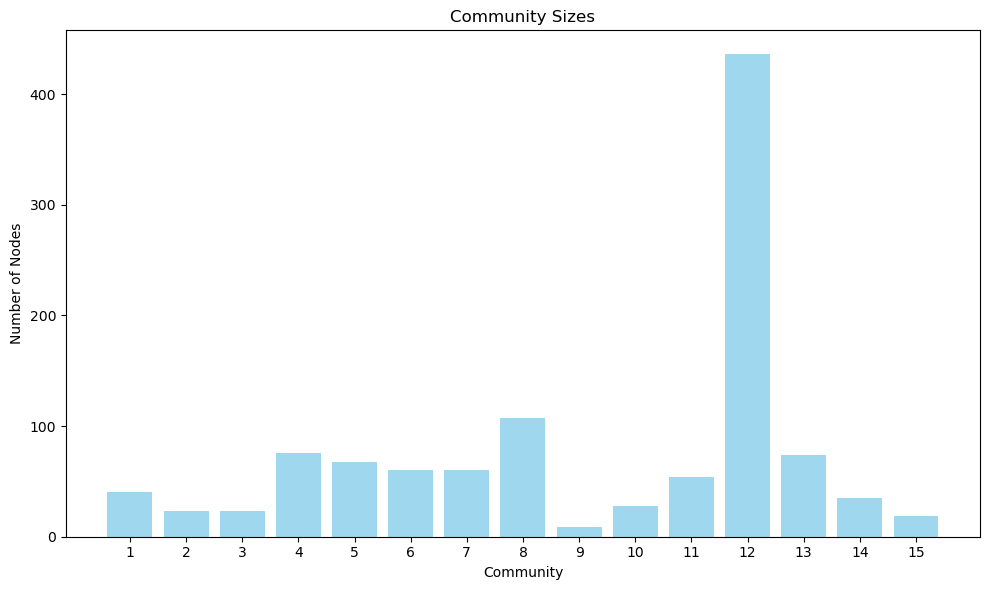

In [61]:
import matplotlib.pyplot as plt

# Plot community size distribution
#plt.figure(figsize=(8, 6))
#plt.hist(community_sizes, bins=10, color="skyblue", edgecolor="black")
#plt.xlabel("Community Size")
#plt.ylabel("Number of Communities")
#plt.title("Distribution of Community Sizes")
#plt.show()
#isto ta mal acho eu 

community_numbers = list(range(1, len(community_sizes) + 1))

# Plot
plt.figure(figsize=(10, 6))
plt.bar(community_numbers, community_sizes, color='skyblue', alpha=0.8)
plt.title("Community Sizes")
plt.xlabel("Community")
plt.ylabel("Number of Nodes")
plt.xticks(community_numbers)  # Set custom x-ticks to show community numbers
plt.tight_layout()
plt.show()

In [62]:
# Compute centrality measures
degree_centrality = nx.degree_centrality(subset_G)

# Identify top nodes in each community
for idx, community in enumerate(communities):
    top_node = max(community, key=lambda node: degree_centrality[node])
    print(f"Community {idx + 1}: Top node {top_node} (Degree Centrality: {degree_centrality[top_node]:.3f})")


Community 1: Top node 25110374 (Degree Centrality: 0.032)
Community 2: Top node 18057537 (Degree Centrality: 0.020)
Community 3: Top node 746323 (Degree Centrality: 0.053)
Community 4: Top node 3359851 (Degree Centrality: 0.103)
Community 5: Top node 7861312 (Degree Centrality: 0.111)
Community 6: Top node 30313925 (Degree Centrality: 0.090)
Community 7: Top node 10350 (Degree Centrality: 0.131)
Community 8: Top node 13348 (Degree Centrality: 0.131)
Community 9: Top node 815587 (Degree Centrality: 0.014)
Community 10: Top node 2735631 (Degree Centrality: 0.026)
Community 11: Top node 16129920 (Degree Centrality: 0.050)
Community 12: Top node 813286 (Degree Centrality: 1.672)
Community 13: Top node 14511951 (Degree Centrality: 0.063)
Community 14: Top node 8170292 (Degree Centrality: 0.046)
Community 15: Top node 5988062 (Degree Centrality: 0.023)


In [63]:
# Intra-community edges
def intra_community_edges(graph, community):
    return graph.subgraph(community).number_of_edges()

# Inter-community edges
def inter_community_edges(graph, community1, community2):
    return len([
        (u, v) for u in community1 for v in community2 if graph.has_edge(u, v)
    ])

# Compute edge metrics
for idx, community in enumerate(communities):
    intra_edges = intra_community_edges(subset_G, community)
    print(f"Community {idx + 1}: {len(community)} nodes, {intra_edges} intra-community edges")


Community 1: 40 nodes, 158 intra-community edges
Community 2: 23 nodes, 84 intra-community edges
Community 3: 23 nodes, 148 intra-community edges
Community 4: 76 nodes, 374 intra-community edges
Community 5: 68 nodes, 312 intra-community edges
Community 6: 60 nodes, 314 intra-community edges
Community 7: 60 nodes, 513 intra-community edges
Community 8: 107 nodes, 1253 intra-community edges
Community 9: 9 nodes, 42 intra-community edges
Community 10: 28 nodes, 97 intra-community edges
Community 11: 54 nodes, 266 intra-community edges
Community 12: 436 nodes, 1058 intra-community edges
Community 13: 74 nodes, 251 intra-community edges
Community 14: 35 nodes, 148 intra-community edges
Community 15: 19 nodes, 58 intra-community edges


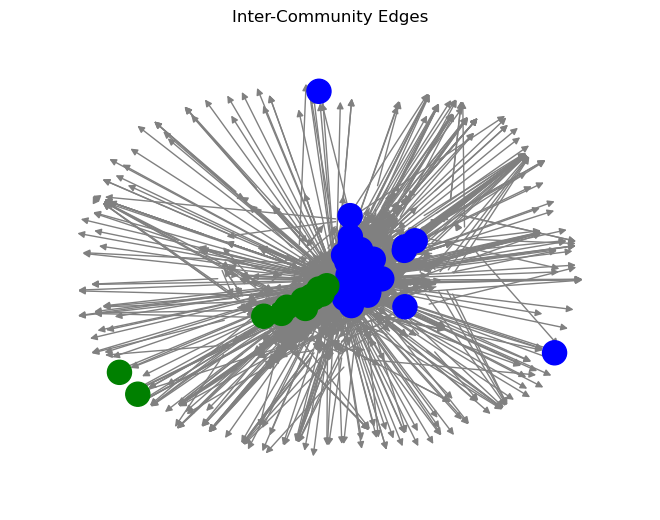

In [64]:
def visualize_inter_community_edges(graph, comm1, comm2):
    pos = nx.spring_layout(graph)
    nx.draw(
        graph, pos,
        nodelist=list(comm1) + list(comm2),
        node_color=["blue"] * len(comm1) + ["green"] * len(comm2),
        with_labels=False,
        edge_color="gray"
    )
    nx.draw_networkx_edges(
        graph, pos,
        edgelist=[(u, v) for u in comm1 for v in comm2 if graph.has_edge(u, v)],
        edge_color="red"
    )
    plt.title("Inter-Community Edges")
    plt.show()

# Visualize edges between Community 1 and Community 2
visualize_inter_community_edges(subset_G, communities[0], communities[1])


In [65]:
from networkx.algorithms.community.quality import modularity

# Compute modularity
modularity_score = modularity(subset_G, communities)
print(f"Modularity of the partition: {modularity_score:.3f}")

for idx, community in enumerate(communities):
    subgraph = subset_G.subgraph(community)
    density = nx.density(subgraph)
    print(f"Community {idx + 1}: Density = {density:.3f}")


Modularity of the partition: 0.508
Community 1: Density = 0.101
Community 2: Density = 0.166
Community 3: Density = 0.292
Community 4: Density = 0.066
Community 5: Density = 0.068
Community 6: Density = 0.089
Community 7: Density = 0.145
Community 8: Density = 0.110
Community 9: Density = 0.583
Community 10: Density = 0.128
Community 11: Density = 0.093
Community 12: Density = 0.006
Community 13: Density = 0.046
Community 14: Density = 0.124
Community 15: Density = 0.170


In [66]:
import pandas as pd

nodeId_file_path = "twitter/12831.edges"  # Replace with your dataset path
c = nx.read_edgelist(nodeId_file_path,create_using=nx.DiGraph) #edges are directed

ego_node = '12831'
nodes_in_graph = list(nodeId_G.nodes())
# Add edges from the ego node to every other node
for node in nodes_in_graph:
    if node != ego_node:
        nodeId_G.add_edge(ego_node, node)


# Load features
feat_file = "twitter/12831.feat"
features_df = pd.read_csv(feat_file, sep='\\s+', header=None)

# Separate node IDs and feature vectors
node_ids = features_df.iloc[:, 0]  # First column: node IDs
feature_vectors = features_df.iloc[:, 1:]  # Remaining columns: binary features

node_feature_dict = features_df.set_index(0).T.to_dict('list')

# Check the size of the ego features
ego_feat_file = "twitter/12831.egofeat"
ego_features = pd.read_csv(ego_feat_file, sep='\\s+', header=None).iloc[0].tolist()
print(f"Ego Features Size: {len(ego_features)}")

# Add ego features to the dictionary (optional)
node_feature_dict[12831] = ego_features



Ego Features Size: 1364


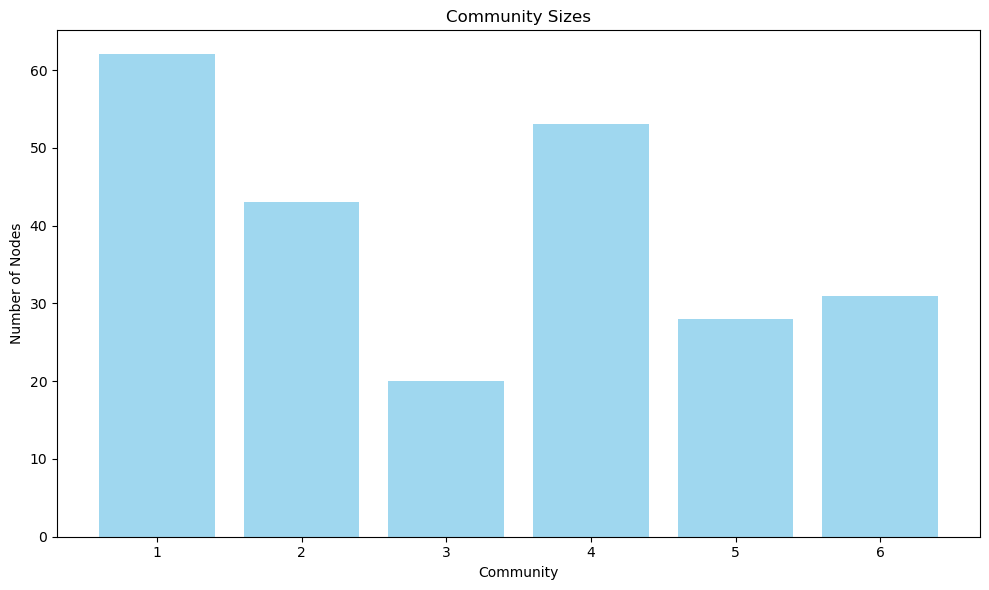

In [67]:
community_features = []



nodeId_communities = louvain_communities(nodeId_G, resolution=1, threshold=1e-07, seed=42)

for idx, community in enumerate(nodeId_communities):
    # Get feature vectors for all nodes in the community
    community_nodes = [int(node) for node in community if int(node) in node_feature_dict]
    community_feats = [node_feature_dict[node] for node in community_nodes]
    
    # Aggregate features (e.g., sum or average)
    if community_feats:
        aggregated_features = pd.DataFrame(community_feats).mean(axis=0).tolist()  # Average features
    else:
        aggregated_features = []
    
    community_features.append({
        "Community": idx,
        "Nodes": len(community_nodes),
        "Aggregated Features": aggregated_features
    })

nodeId_community_sizes = [len(community) for community in nodeId_communities]
community_numbers = list(range(1, len(nodeId_community_sizes) + 1))

# Plot
plt.figure(figsize=(10, 6))
plt.bar(community_numbers, nodeId_community_sizes, color='skyblue', alpha=0.8)
plt.title("Community Sizes")
plt.xlabel("Community")
plt.ylabel("Number of Nodes")
plt.xticks(community_numbers)  # Set custom x-ticks to show community numbers
plt.tight_layout()
output_path = "12831_communities.png"  # Change the name or format if needed
plt.savefig(output_path, format="png", dpi=300)
plt.show()




Total Features: 1364
Community 1:
  Number of Nodes: 62
Community 2:
  Number of Nodes: 43
Community 3:
  Number of Nodes: 20
Community 4:
  Number of Nodes: 53
Community 5:
  Number of Nodes: 28
Community 6:
  Number of Nodes: 31


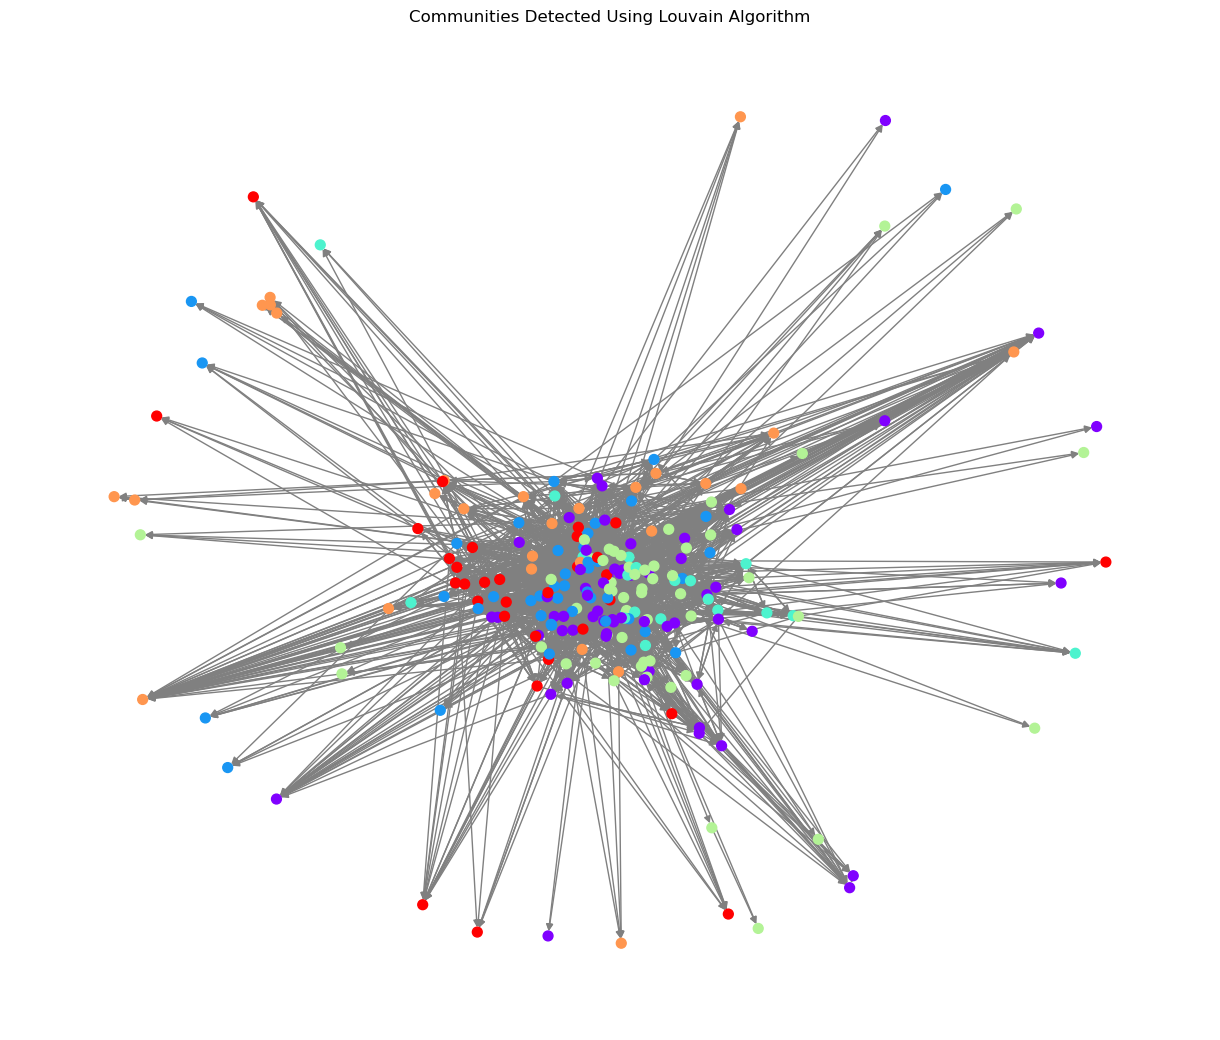

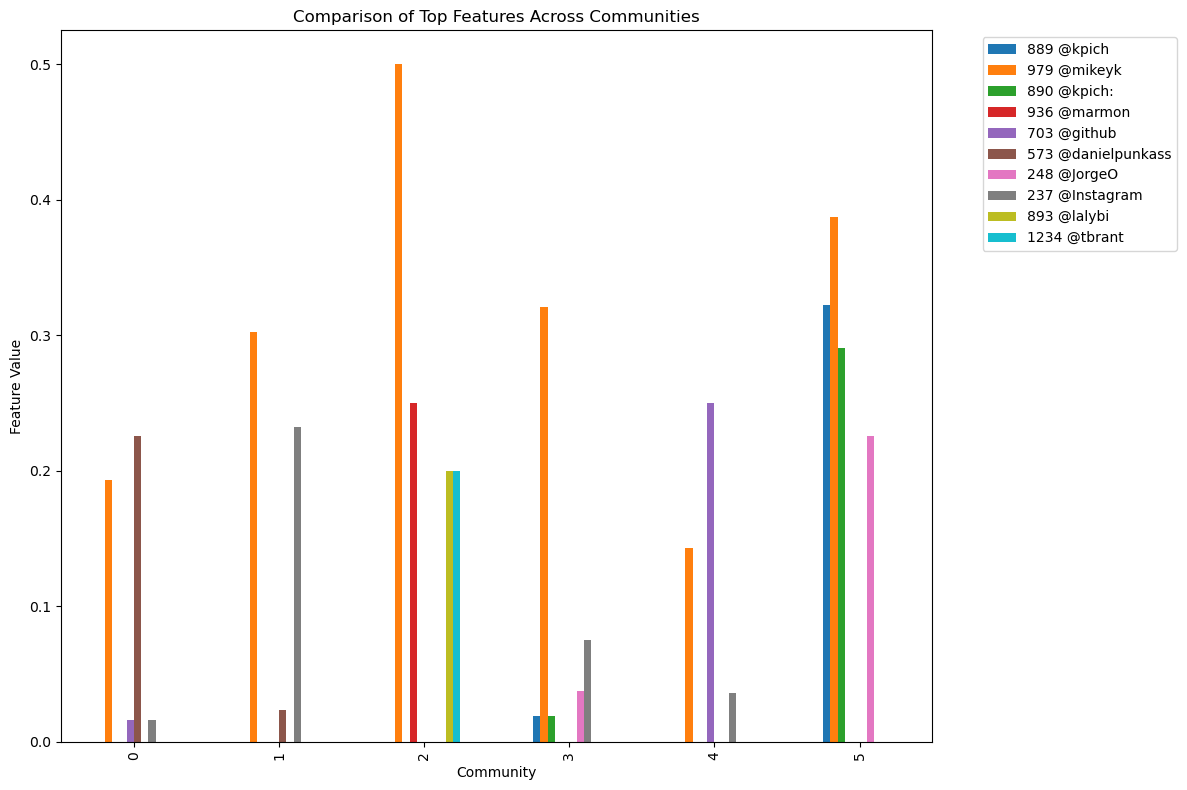

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

featnames_file = "twitter/12831.featnames"

# Open the file with UTF-8 encoding
with open(featnames_file, "r", encoding="utf-8") as f:
    feature_names = [line.strip() for line in f]

# Ensure the number of feature names matches the feature vector length
print(f"Total Features: {len(feature_names)}")

# Assuming `community_features` is already computed
community_features = []



for idx, community in enumerate(nodeId_communities):
    # Get feature vectors for all nodes in the community
    community_nodes = [int(node) for node in community]
    community_feats = [node_feature_dict[node] for node in community_nodes]
    
    # Aggregate features (e.g., sum or average)
    if community_feats:
        aggregated_features = pd.DataFrame(community_feats).mean(axis=0).tolist()  # Average features
    else:
        aggregated_features = []
    
    # Map aggregated features to feature names
    feature_summary = dict(zip(feature_names, aggregated_features)) if aggregated_features else {}

    community_features.append({
        "Community": idx + 1,
        "Nodes": len(community_nodes),
        "Feature Summary": feature_summary
    })

# Print summary of community features with feature names
for cf in community_features:
    print(f"Community {cf['Community']}:")
    print(f"  Number of Nodes: {cf['Nodes']}")


def plot_feature_comparison(community_features, top_k=10, output_file="feature_comparison.png"):
    # Extract features for visualization as a DataFrame
    feature_df = pd.DataFrame([
        cf["Feature Summary"] for cf in community_features
    ])
    
    # Find top-k most variable features across communities
    variances = feature_df.var(axis=0)
    top_features = variances.nlargest(top_k).index  # These are feature names (strings)
    
    # Plot
    feature_df[top_features].plot(kind='bar', figsize=(12, 8))
    plt.title("Comparison of Top Features Across Communities")
    plt.xlabel("Community")
    plt.ylabel("Feature Value")
    
    # Use top_features directly for the legend
    plt.legend(top_features, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(output_file, format="png", dpi=300)  # Save with high resolution
    
    plt.show()


visualize_communities(nodeId_G, nodeId_communities)
# Call plotting function and save the graph
plot_feature_comparison(community_features, top_k=10, output_file="ScreenShots/feature_comparison.png")

